## softmax

In [82]:
import pandas as pd
import numpy as np
fish=pd.read_csv("http://bit.ly/fish_csv_data")

### 다중분류를 위해 데이터 시각화

In [83]:
target=["Species"]
feature=fish.columns.difference(target)

In [84]:
import matplotlib.pyplot as plt
import seaborn as sb

<Axes: >

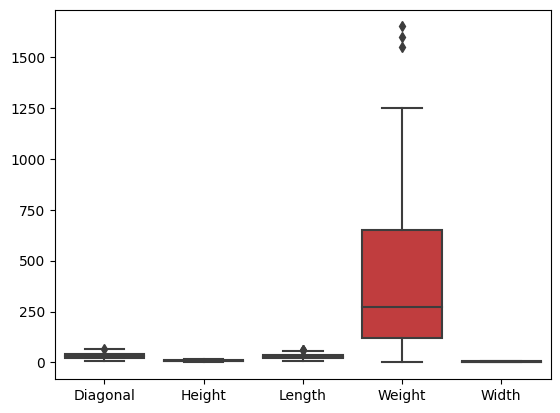

In [85]:
plt.figure()
sb.boxplot(data=fish[feature])

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

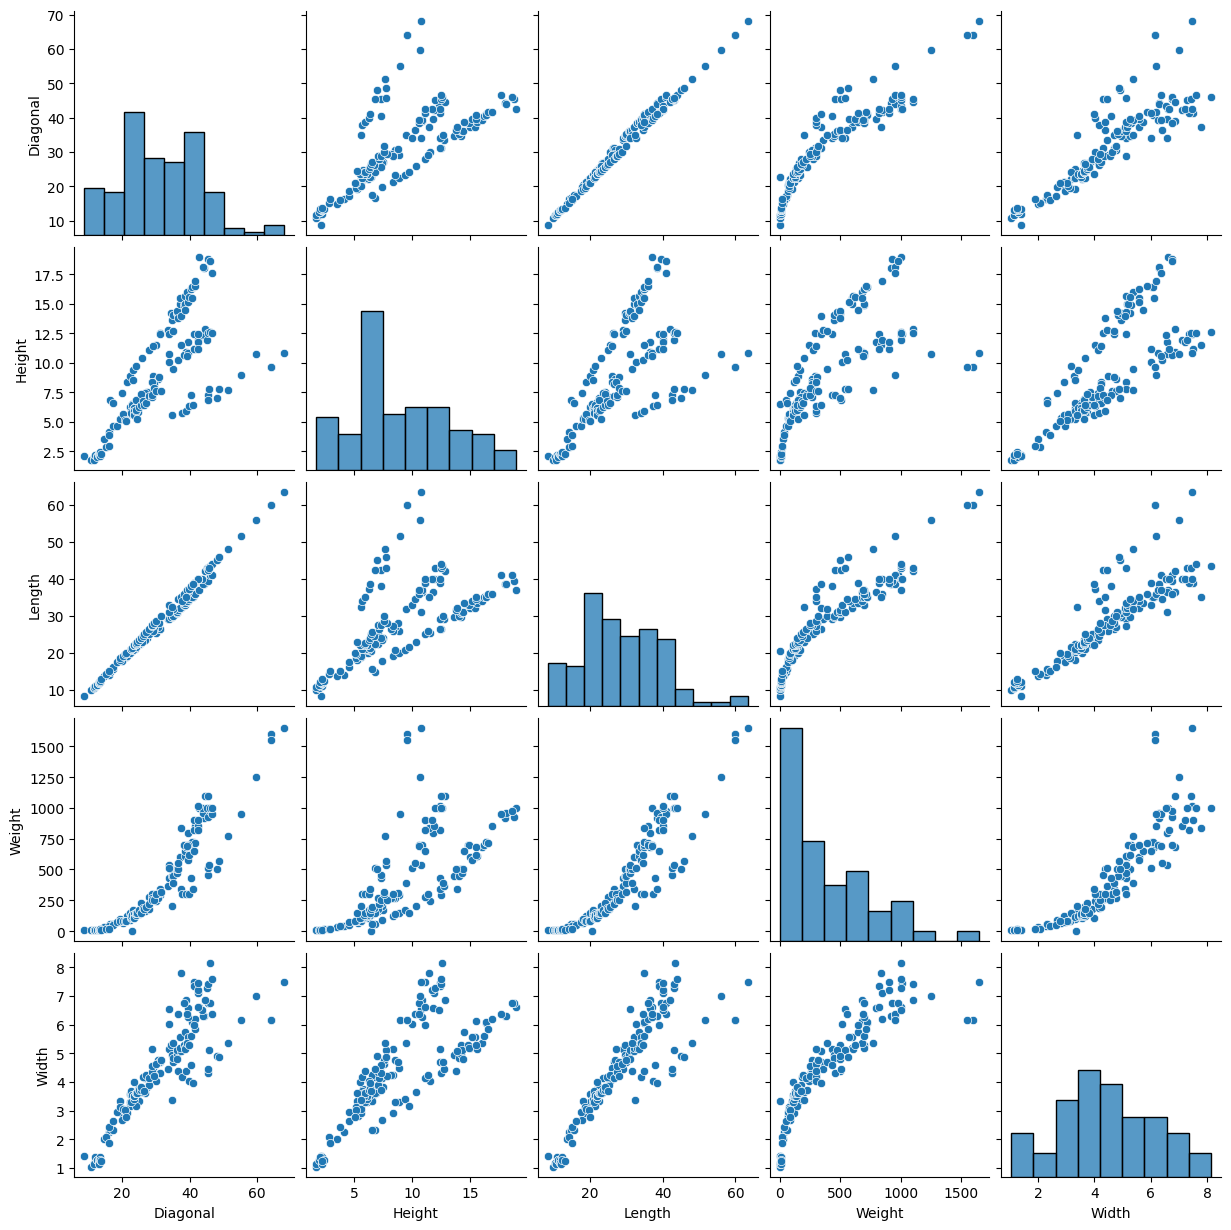

In [86]:
plt.figure()
sb.pairplot(data=fish[feature])
plt.show()
plt.close()

위의 결과를 보아 전처리 및 다중공선성 제거가 반드시 필요해보임

### 다중공선성

In [87]:
fish[feature]

,Diagonal,Height,Length,Weight,Width
0,30.0,11.5200,25.4,242.0,4.0200
1,31.2,12.4800,26.3,290.0,4.3056
2,31.1,12.3778,26.5,340.0,4.6961
3,33.5,12.7300,29.0,363.0,4.4555
4,34.0,12.4440,29.0,430.0,5.1340
...,...,...,...,...,...
154,13.4,2.0904,12.2,12.2,1.3936
155,13.5,2.4300,12.4,13.4,1.2690
156,13.8,2.2770,13.0,12.2,1.2558
157,15.2,2.8728,14.3,19.7,2.0672


In [88]:
import statsmodels.api as sm

In [89]:
vif=[]
for col in feature:
    model=sm.OLS(endog=fish[col],exog=fish[[x for x in feature if x!=col]]).fit()
    r=model.rsquared
    vif.append({'col':col,'vif':1/(1-r)})

In [90]:
pd.DataFrame(vif)

,col,vif
0,Diagonal,3549.523336
1,Height,74.785638
2,Length,3518.042578
3,Weight,6.445267
4,Width,94.049555


다중공선성 제거

In [91]:
while True:
    vif=[]
    for col in feature:
        model=sm.OLS(endog=fish[col],exog=fish[[x for x in feature if x!=col]]).fit()
        r=model.rsquared
        vif.append({'col':col,'vif':1/(1-r)})
    # 두개 미만의 feature 사용 방지
    if len(vif)<=2:
        break
    # 다중공선성 문제 해결시 완료
    if all(map(lambda x:True if x<5 else False,[x["vif"] for x in vif])):
        break
    vif.sort(key=lambda x:x["vif"],reverse=True)
    feature=feature.drop(vif[0]["col"])

In [92]:
pd.DataFrame(vif)

,col,vif
0,Height,4.442226
1,Weight,4.442226


### 데이터 분리
> 이떄 데이터가 굉장히 부족한 `Species`가 있음          
이를 고려하여 층화추출을 시도하겠음

<Axes: xlabel='Height', ylabel='Weight'>

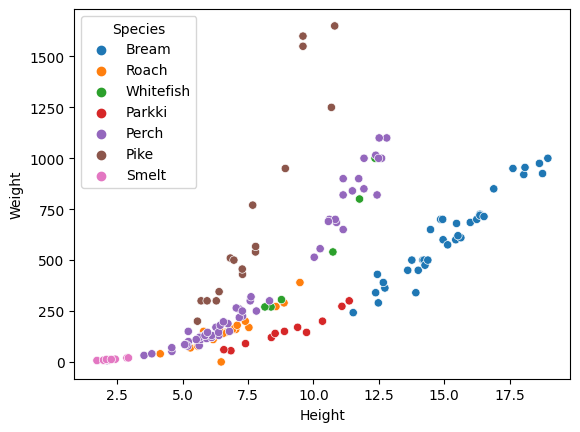

In [93]:
plt.figure()
sb.scatterplot(data=fish,x='Height',y='Weight',hue='Species')

범위가 굉장히 다르므로, minmax scale 혹은 standard scale을 할것.

In [94]:
fish[feature].describe().T

,count,mean,std,min,25%,50%,75%,max
Height,159.0,8.970994,4.286208,1.7284,5.9448,7.786,12.3659,18.957
Weight,159.0,398.326415,357.978317,0.0000,120.0000,273.000,650.0000,1650.000


In [95]:
import sklearn.model_selection as skmod
import scipy as sp
import sklearn.linear_model as sklin
import sklearn.preprocessing as skpre

In [96]:
fish[feature]=skpre.scale(X=fish[feature])

In [97]:
import numpy as np
np.random.seed(10)

데이터 분리

In [98]:
train,test=skmod.train_test_split(fish,train_size=0.7,random_state=10,stratify=fish["Species"])

학습

In [99]:
model=sklin.LogisticRegression()
model.fit(X=train[feature],y=train["Species"])

LogisticRegression()

### 모델의 해석

default가 accuaracy 이다

In [100]:
model.score(train[feature],train["Species"])

0.6846846846846847

예측에 대한 해석

In [101]:
predict=pd.DataFrame(model.predict(test[feature])).rename(columns={0:'predict'}).set_index(test.index)
predict=pd.merge(test[feature],predict,right_index=True,left_index=True)

<Axes: xlabel='Height', ylabel='Weight'>

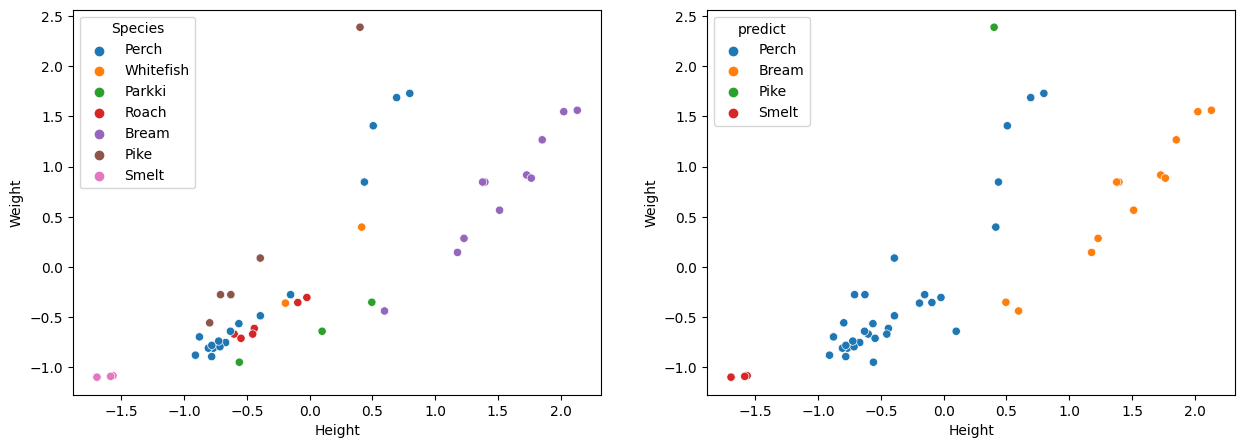

In [102]:
_,a=plt.subplots(1,2,figsize=(15,5))
sb.scatterplot(data=test,x='Height',y='Weight',hue='Species',ax=a[0])
sb.scatterplot(data=predict,x='Height',y='Weight',hue='predict',ax=a[1])

위의 결과를 보아 `코사인 거리`를 이용한 KNN이 더 높은 정답률을 보일것으로 예상됨.

#### 소프트맥스를 이용한 결과 확률 추출

In [109]:
softmax=pd.DataFrame(sp.special.softmax(model.decision_function(X=test[feature]),axis=1))

In [110]:
colname=sorted(list(test["Species"].unique()),reverse=True)

In [111]:
softmax.rename(columns=dict(zip(softmax.columns,colname)),inplace=True)

아래가 각각의 예측 확률이다

In [113]:
softmax.apply(lambda x:np.round(x*100,decimals=1))

,Whitefish,Smelt,Roach,Pike,Perch,Parkki,Bream
0,11.1,2.2,60.5,15.1,2.7,0.0,8.4
1,18.4,5.8,54.0,8.0,5.7,0.1,7.9
2,37.3,20.5,24.6,1.3,11.7,0.1,4.4
3,9.0,13.7,49.1,5.6,16.6,0.8,5.3
4,1.6,9.7,50.1,8.5,21.7,4.9,3.4
5,80.6,6.8,7.9,0.3,2.0,0.0,2.5
6,0.5,8.8,39.1,7.2,26.5,15.9,2.0
7,1.3,11.2,43.8,6.8,26.1,8.0,2.7
8,96.3,0.3,2.0,0.1,0.0,0.0,1.3
9,2.9,11.2,50.9,7.6,20.5,2.9,4.0
